# Introduction

This notebook contains experiments for the navigation project using the Unity Banana Environment. DQN algorithms and several enhancement to it have been tried and their effect on the evolution of score is presented in the plot section of the notebook. The base algorithm for DQN uses the target network, the soft update and the prioritized experience replay buffer (refered to as PER from now on). Two enhancements on top of the base case are implemented, namely: Double DQN and Dueling Networks. For each case, seven runs are performed and the scores are stored in separate json files. 

Whenever an agent hit the threshold score of `13.0`, the weights and other meta data from the agents are saved in `experiment_checkpoint_solved.pth`. Same data, namely the weights of the agent and its meta data are saved at the end of the experiment under `experiment_checkpoint_last.pth`. 

In [1]:
from dqn import run_experiment1, Config
from unityagents import UnityEnvironment
import json

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Case1: Prioritized Experience Replay (PER)

In [3]:
config = Config(
    seed=101, batch_size=64, n_episodes=600, lr=1e-4,
    #
    gamma=0.99, update_every=4, soft_update=1e-3,
    #
    buffer_size=100_000, buffer_alpha=0.6, buffer_beta=0.4, buffer_eps=1e-5, buffer_beta_anneal_steps=100_000,
    #
    dueling_network=False,
    double_dqn=False,
    #
    t_max=500, score_threshold=13.0, score_window=100, eps_init=1.0, eps_final=0.01, eps_decay=0.975,
    #
    device='cpu'
) 

In [4]:
case1_scores = []
for _ in range(7):
    case1_scores.append(
        run_experiment1(config, env)
    )

with open('case1_scores.json', 'w') as f:
    json.dump(case1_scores, f)

Episode: 100%|██████████████████████████████████████████████████| 600/600 [07:39<00:00,  1.31it/s, score=18.0, mean_score=12.12, eps=0.0100]


## Case 2: PER and Double-DQN 

In [5]:
config.double_dqn = True
config.dueling_network = False

In [6]:
case2_scores = []
for _ in range(7):
    case2_scores.append(
        run_experiment1(config, env)
    )  

with open('case2_scores.json', 'w') as f:
    json.dump(case2_scores, f)

Solved in 458: 100%|████████████████████████████████████████████| 600/600 [07:44<00:00,  1.29it/s, score=13.0, mean_score=13.94, eps=0.0100]


## Case 3: PER, Double-DQN and Dueling Network

In [7]:
config.double_dqn = True
config.dueling_network = True

In [8]:
case3_scores = []
for _ in range(7):
    case3_scores.append(
        run_experiment1(config, env)
    )

with open('case3_scores.json', 'w') as f:
    json.dump(case3_scores, f)

Solved in 385: 100%|████████████████████████████████████████████| 600/600 [08:03<00:00,  1.24it/s, score=16.0, mean_score=13.76, eps=0.0100]


Close the environment after all the experiment are done

In [9]:
env.close()

# Plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [2]:
with open('case1_scores.json') as f:
    case1_scores = json.load(f)

with open('case2_scores.json') as f:
    case2_scores = json.load(f)

with open('case3_scores.json') as f:
    case3_scores = json.load(f)

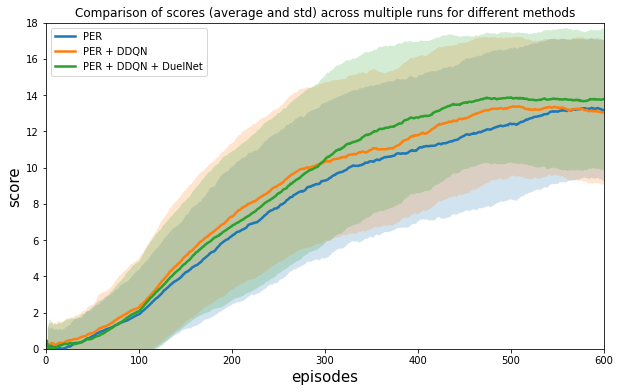

In [13]:
from typing import Tuple


def load_and_pad(filepath, max_episodes=600) -> np.ndarray:
    with open(filepath) as f:
        arr = json.load(f)

    arr1 = np.full((len(arr), max_episodes), np.nan)
    for idx, data in enumerate(arr):
        arr1[idx, : len(data)] = data

    return arr1
    
def sm_curves(arr: np.ndarray, window=100) -> Tuple[np.ndarray, np.ndarray]:
    sm_mean = pd.DataFrame(arr.T).rolling(window, min_periods=1).mean().values.mean(axis=1)
    sm_std = pd.DataFrame(arr.T).rolling(window, min_periods=1).std().values.mean(axis=1)
    # sm_mean = pd.DataFrame(arr.T).rolling(window, min_periods=1).mean().mean(axis=1)
    # sm_std = pd.DataFrame(arr.T).rolling(window, min_periods=1).std().mean(axis=1)
    return sm_mean, sm_std

sm_mean1, sm_std1 = sm_curves(load_and_pad('case1_scores.json'))
sm_mean2, sm_std2 = sm_curves(load_and_pad('case2_scores.json'))
sm_mean3, sm_std3 = sm_curves(load_and_pad('case3_scores.json'))

def plot_helper(ax, sm_mean: np.ndarray, sm_std: np.ndarray, label: str) -> None:
    ax.plot(x, sm_mean, lw=2.5, label=label)
    ax.fill_between(x, sm_mean - sm_std, sm_mean + sm_std, alpha=0.2)

x = np.arange(1, 601)
_, ax = plt.subplots(figsize=(10, 6))

plot_helper(ax, sm_mean1, sm_std1, 'PER')
plot_helper(ax, sm_mean2, sm_std2, 'PER + DDQN')
plot_helper(ax, sm_mean3, sm_std3, 'PER + DDQN + DuelNet')

ax.set_xlim(0, 600)
ax.set_ylim(0, 18)
ax.set_xlabel('episodes', fontsize=15)
ax.set_ylabel('score', fontsize=15)
ax.set_title('Comparison of scores (average and std) across multiple runs for different methods')
ax.legend(loc=2)

In [4]:
data3 = load_and_pad('case3_scores.json')
data3_mean = []
for i in range(data3.shape[0]):
    data3_mean.append(
        np.convolve(data3[i], np.ones(100) / 100, 'full')
    )
data3_mean = np.array(data3_mean)

In [5]:
import torch

In [6]:
data_solved = torch.load('experiment_checkpoint_solved.pth')
data_last = torch.load('experiment_checkpoint_last.pth')

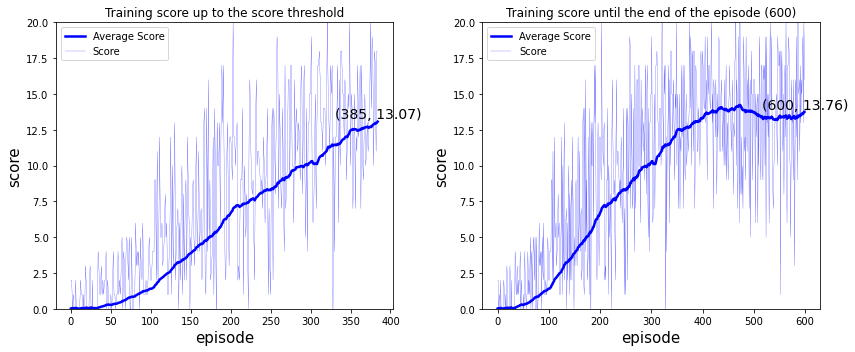

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

def helper_plot(ax, data):
    Y = data['scores']
    score_ave = np.convolve(Y, np.ones(100) / 100, 'full')[:len(Y)]
    ax.plot(score_ave, lw=2.5, color='b', label='Average Score')
    ax.plot(Y, lw=0.2, color='b', label='Score')
    x, y = len(score_ave), score_ave[-1]
    ax.set_ylim(0, 20)
    ax.annotate(f'({x}, {y:.2f})', (x, y), ha='center', va='bottom', fontsize=14)
    ax.set_xlabel('episode', fontsize=15)
    ax.set_ylabel('score', fontsize=15)
    ax.legend()


helper_plot(ax1, data_solved)
helper_plot(ax2, data_last)

ax1.set_title('Training score up to the score threshold')
ax2.set_title('Training score until the end of the episode (600)')

plt.tight_layout()